In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('seaborn')
sns.set_palette("husl")

# Load data with proper settings
service_df = pd.read_csv('../../data/10 year service requests.csv')
inventory_df = pd.read_csv('../../data/Inventory 1-15-26.csv', low_memory=False)

print("Data loaded successfully!")
print(f"Service requests shape: {service_df.shape}")
print(f"Inventory shape: {inventory_df.shape}")

Data loaded successfully!
Service requests shape: (64614, 14)
Inventory shape: (189382, 18)


In [39]:
service_df.head()

,Rec#,Name,Q,A,Street,Div,D,Service,EnterDt,PrintDt,ResolvDt,SanTruck,Rt,InspBy
0,2642405,",",348,2039,N 41ST ST,Forestry,1.0,Broken Branch Down blocking driveway,2016-01-28 12:30,2016-01-28 13:57,2016-01-28 14:19,NaN,CP4-3D,ab
1,2642406,",",348,2041,N 41ST ST,Forestry,1.0,Broken Branch Down blocking driveway,2016-01-28 12:31,2016-01-28 13:57,2016-01-28 13:58,NaN,CP4-3D,NaN
2,2650087,"NEUMANN,JON",318,2506,N TERRACE AV,Forestry,1.0,Broken Branch Down blocking driveway,2016-02-19 13:35,2016-02-19 14:57,2016-02-19 15:25,NaN,CP1-3B,AB
3,2650318,",",549,171,W TRIPOLI AV,Forestry,2.0,Broken Branch Down blocking driveway,2016-02-19 17:55,2016-02-22 06:50,2016-02-23 10:07,NaN,SP4-5C,dv
4,2657829,"WARD,ISAAC",231,4566,N 24TH ST,Forestry,3.0,Broken Branch Down blocking driveway,2016-03-10 16:30,NaN,2016-03-11 07:43,NaN,NP4-6C,DV


In [40]:
inventory_df.head()

,Site ID,Quarter Section,Address,Street,Side,Site,On Street,Species,DBH,Latitude,Longitude,Inventory Date,Condition,Alder,District,Property Type,Pruning Cycle,Site Comments
0,166587,537,3407,1ST PL /S,Side,1,HOLT AV /W,"MAPLE, NORWAY (NOR) (ACER PLATANOIDES)",12.0,42.982287,-87.912201,01/25/2010,Good,14,South,Residential,5,NaN
1,166592,537,3407,1ST PL /S,Side,2,HOLT AV /W,"PEAR, CALLERY CHANTICLEER (CCP) (PYRUS CALLERY...",4.0,42.982285,-87.912369,01/25/2010,Good,14,South,Residential,5,Uprooting in north wind
2,166828,537,3410,1ST PL /S,Front,1,1ST PL /S,"MAPLE, NORWAY (NOR) (ACER PLATANOIDES)",12.0,42.982162,-87.911876,01/25/2010,Good,14,South,Residential,5,NaN
3,166831,537,3413,1ST PL /S,Front,1,1ST PL /S,"MAPLE, NORWAY (NOR) (ACER PLATANOIDES)",17.0,42.982124,-87.912015,01/25/2010,Good,14,South,Residential,5,NaN
4,166834,537,3419,1ST PL /S,Front,1,1ST PL /S,"HONEYLOCUST, THORNLESS SKYLINE (SKL) (GLEDITSI...",3.0,42.982006,-87.912013,10/25/2019,Good,14,South,Residential,5,NaN


# Exploratory Data Analysis: Tree Pruning Prioritization Model

## Focus: Identifying traits that correlate with tree failure, with emphasis on species analysis


In [41]:
# Basic data exploration
print("=== SERVICE REQUESTS DATA ===")
print(f"Total service requests: {len(service_df):,}")
print(f"\nColumns: {list(service_df.columns)}")
print(f"\nMissing values:")
print(service_df.isnull().sum().sort_values(ascending=False))
print(f"\nData types:")
print(service_df.dtypes)

print("\n=== INVENTORY DATA ===")
print(f"Total trees in inventory: {len(inventory_df):,}")
print(f"\nColumns: {list(inventory_df.columns)}")
print(f"\nMissing values:")
print(inventory_df.isnull().sum().sort_values(ascending=False))
print(f"\nData types:")
print(inventory_df.dtypes)


=== SERVICE REQUESTS DATA ===
Total service requests: 64,614

Columns: ['Rec#', 'Name', 'Q', 'A', 'Street', 'Div', 'D', 'Service', 'EnterDt', 'PrintDt', 'ResolvDt', 'SanTruck', 'Rt', 'InspBy']

Missing values:
SanTruck    64612
PrintDt     40780
InspBy      40000
ResolvDt     1989
Div            16
D              11
Rt              3
Street          0
Q               0
Name            0
Rec#            0
A               0
EnterDt         0
Service         0
dtype: int64

Data types:
Rec#          int64
Name         object
Q            object
A             int64
Street       object
Div          object
D           float64
Service      object
EnterDt      object
PrintDt      object
ResolvDt     object
SanTruck     object
Rt           object
InspBy       object
dtype: object

=== INVENTORY DATA ===
Total trees in inventory: 189,382

Columns: ['Site ID', 'Quarter Section', 'Address', 'Street', 'Side', 'Site', 'On Street', 'Species', 'DBH', 'Latitude', 'Longitude', 'Inventory Date', 'Conditi

In [42]:
# Analyze service request types - categorize tree failures
print("=== SERVICE REQUEST TYPES ===")
print(f"Unique service types: {service_df['Service'].nunique()}")
print(f"\nTop 20 service request types:")
print(service_df['Service'].value_counts().head(20))

# Categorize service requests into failure types
def categorize_failure(service_text):
    """Categorize service requests into failure types"""
    if pd.isna(service_text):
        return 'Unknown'
    service_lower = str(service_text).lower()
    
    # Branch failures
    if any(word in service_lower for word in ['branch', 'limb', 'broken branch', 'hanging branch']):
        return 'Branch Failure'
    # Tree failure/fall
    elif any(word in service_lower for word in ['tree down', 'tree fall', 'uprooted', 'fallen tree']):
        return 'Tree Failure'
    # Structural issues
    elif any(word in service_lower for word in ['split', 'crack', 'structural', 'hazard', 'dead']):
        return 'Structural Issue'
    # Root problems
    elif any(word in service_lower for word in ['root', 'heaving', 'lifting']):
        return 'Root Issue'
    # Pruning requests
    elif any(word in service_lower for word in ['prune', 'trim', 'trimming']):
        return 'Pruning Request'
    # Other
    else:
        return 'Other'

service_df['Failure_Category'] = service_df['Service'].apply(categorize_failure)

print("\n=== FAILURE CATEGORIES ===")
print(service_df['Failure_Category'].value_counts())
print(f"\nPercentage breakdown:")
print(service_df['Failure_Category'].value_counts(normalize=True) * 100)


=== SERVICE REQUEST TYPES ===
Unique service types: 17

Top 20 service request types:
Service
Broken Branch Down not blocking              21247
Trim tree                                    16207
Broken Branch Down blocking street            5005
Broken Branch Down blocking sidewalk          4751
Tree down                                     3055
Broken Branch Hanging over sidewalk           2990
Tree damage                                   2976
Broken Branch Hanging over street             2901
Tree split                                    1276
Broken Branch Hanging other                   1081
Broken Branch Down blocking driveway           850
Broken Branch Down on car                      650
Branches / bushes blocking sign                615
Broken Branch Down on house                    434
Broken Branch Hanging over tree lawn           404
Broken Branch Down on porch                    136
Broken Branch Down blocking traffic light       36
Name: count, dtype: int64

=== FAILURE 

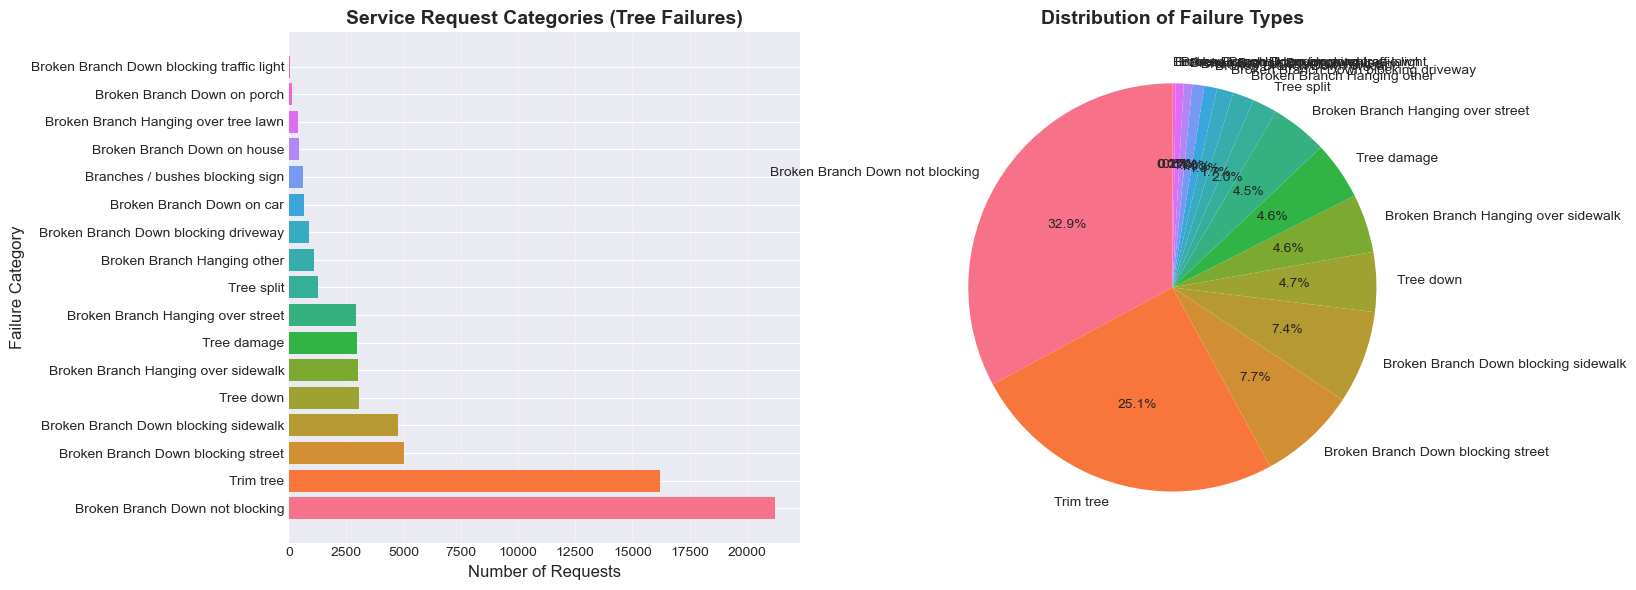

In [43]:
# Visualize failure categories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count plot
failure_counts = service_df['Service'].value_counts()
axes[0].barh(failure_counts.index, failure_counts.values, color=sns.color_palette("husl", len(failure_counts)))
axes[0].set_xlabel('Number of Requests', fontsize=12)
axes[0].set_ylabel('Failure Category', fontsize=12)
axes[0].set_title('Service Request Categories (Tree Failures)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Pie chart
axes[1].pie(failure_counts.values, labels=failure_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette("husl", len(failure_counts)))
axes[1].set_title('Distribution of Failure Types', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [44]:
# Analyze inventory data - species distribution
print("=== SPECIES ANALYSIS ===")
print(f"Total unique species: {inventory_df['Species'].nunique()}")
print(f"\nTop 20 species by count:")
top_species = inventory_df['Species'].value_counts().head(20)
print(top_species)

# Clean species names for better analysis
def extract_species_name(full_name):
    """Extract main species name from full description"""
    if pd.isna(full_name):
        return 'Unknown'
    # Take first part before comma or parentheses
    name = str(full_name).split(',')[0].strip()
    # Remove common prefixes
    name = name.replace('MAPLE, ', '').replace('OAK, ', '').replace('ASH, ', '')
    return name

inventory_df['Species_Simple'] = inventory_df['Species'].apply(extract_species_name)
print(f"\nUnique simplified species: {inventory_df['Species_Simple'].nunique()}")
print(f"\nTop 20 simplified species:")
print(inventory_df['Species_Simple'].value_counts().head(20))


=== SPECIES ANALYSIS ===
Total unique species: 391

Top 20 species by count:
Species
MAPLE, NORWAY (NOR) (ACER PLATANOIDES)                                            49823
ASH, GREEN (GRA) (FRAXINUS PENNSYLVANICA)                                         21667
HONEYLOCUST, THORNLESS (LOC) (GLEDITSIA TRIACANTHOS INERMIS)                      15524
HACKBERRY, AMERICAN (HAC) (CELTIS OCCIDENTALIS)                                    7082
MAPLE, NORWAY COLUMNARE (COL) (ACER PLATANOIDES (COLUMNARE))                       4417
LINDEN, LITTLELEAF (LIL) (TILIA CORDATA)                                           4188
LILAC, JAPANESE TREE IVORY SILK (ITL) (SYRINGA RETICULATA (IVORY SILK))            3470
MAPLE, NORWAY CRIMSON KING (CKM) (ACER PLATANOIDES (CRIMSON KING))                 3262
HONEYLOCUST, THORNLESS SKYLINE (SKL) (GLEDITSIA TRIACANTHOS INERMIS (SKYLINE))     3148
OAK, SWAMP WHITE (SWO) (QUERCUS BICOLOR)                                           2790
ASH, WHITE (WHA) (FRAXINUS AMERICAN

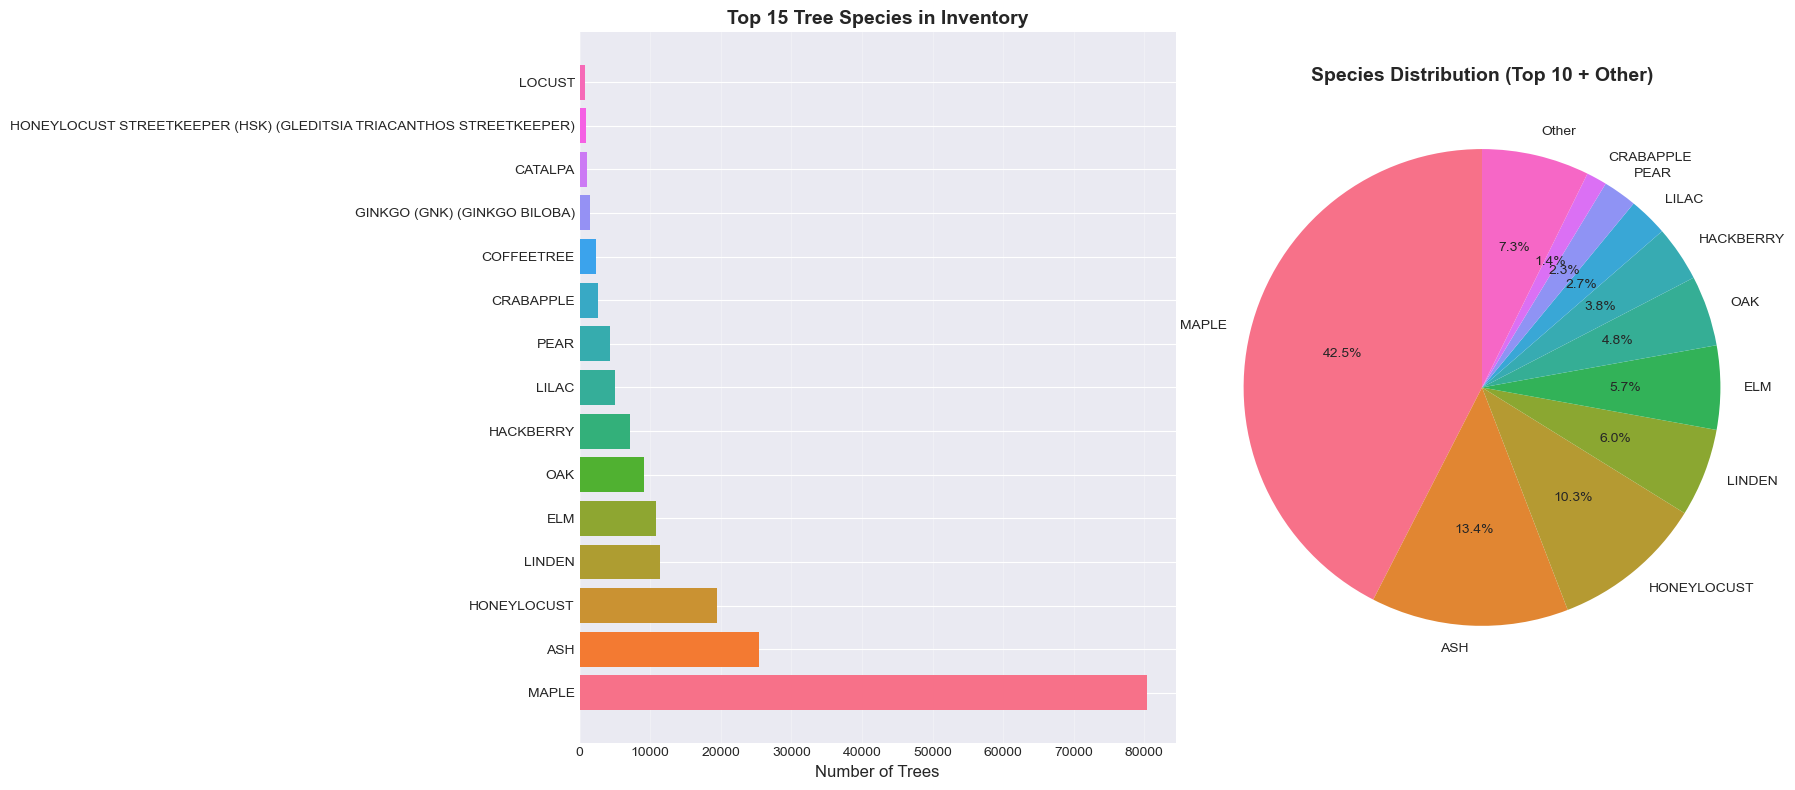

In [45]:
# Visualize species distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top species bar chart
top_15_species = inventory_df['Species_Simple'].value_counts().head(15)
axes[0].barh(range(len(top_15_species)), top_15_species.values, color=sns.color_palette("husl", len(top_15_species)))
axes[0].set_yticks(range(len(top_15_species)))
axes[0].set_yticklabels(top_15_species.index, fontsize=10)
axes[0].set_xlabel('Number of Trees', fontsize=12)
axes[0].set_title('Top 15 Tree Species in Inventory', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Species distribution pie chart (top 10)
top_10_species = inventory_df['Species_Simple'].value_counts().head(10)
other_count = inventory_df['Species_Simple'].value_counts().iloc[10:].sum()
pie_data = list(top_10_species.values) + [other_count]
pie_labels = list(top_10_species.index) + ['Other']

axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90,
            colors=sns.color_palette("husl", len(pie_data)))
axes[1].set_title('Species Distribution (Top 10 + Other)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


=== TREE CONDITION ANALYSIS ===
Condition distribution:
Condition
Good            121379
Fair             55144
Unassigned        5338
Excellent         3672
Poor              3439
Dead               115
Critical            28
recheck site         3
Name: count, dtype: int64

Condition percentages:
Condition
Good            64.181622
Fair            29.158515
Unassigned       2.822576
Excellent        1.941645
Poor             1.818441
Dead             0.060809
Critical         0.014806
recheck site     0.001586
Name: proportion, dtype: float64


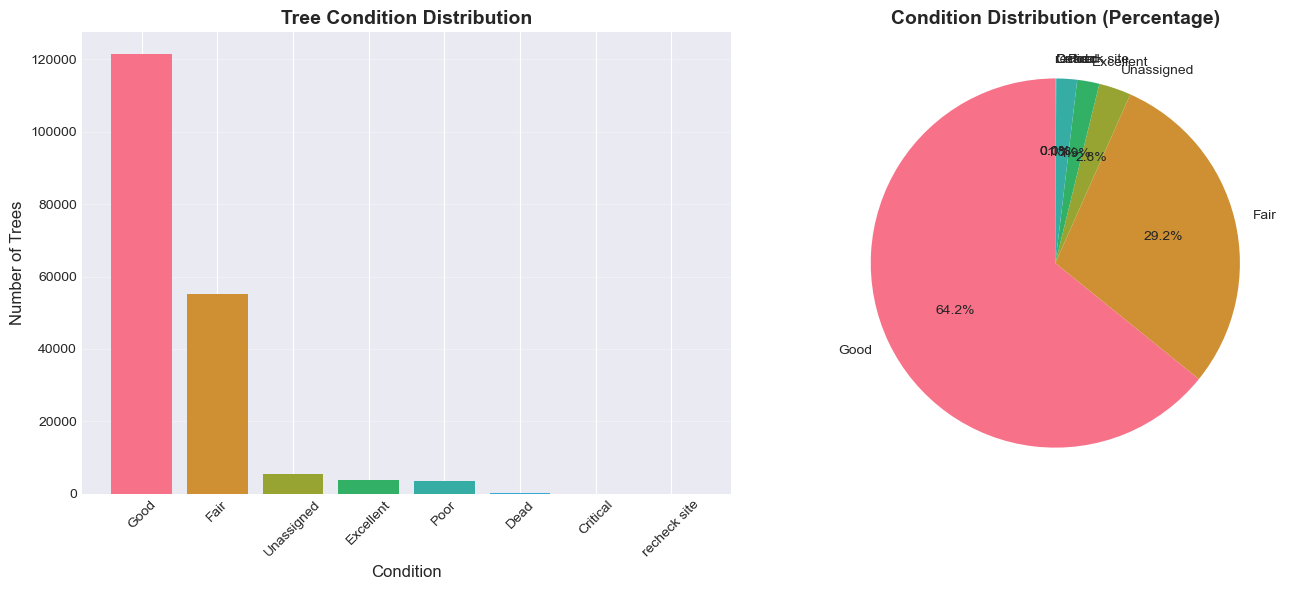

In [46]:
# Analyze tree condition distribution
print("=== TREE CONDITION ANALYSIS ===")
print("Condition distribution:")
print(inventory_df['Condition'].value_counts())
print(f"\nCondition percentages:")
print(inventory_df['Condition'].value_counts(normalize=True) * 100)

# Visualize condition distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

condition_counts = inventory_df['Condition'].value_counts()
axes[0].bar(condition_counts.index, condition_counts.values, color=sns.color_palette("husl", len(condition_counts)))
axes[0].set_xlabel('Condition', fontsize=12)
axes[0].set_ylabel('Number of Trees', fontsize=12)
axes[0].set_title('Tree Condition Distribution', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

axes[1].pie(condition_counts.values, labels=condition_counts.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette("husl", len(condition_counts)))
axes[1].set_title('Condition Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


=== DBH ANALYSIS ===
DBH statistics:
count    189382.000000
mean         12.055718
std           8.449344
min           0.000000
25%           4.000000
50%          12.000000
75%          18.000000
max         234.000000
Name: DBH, dtype: float64


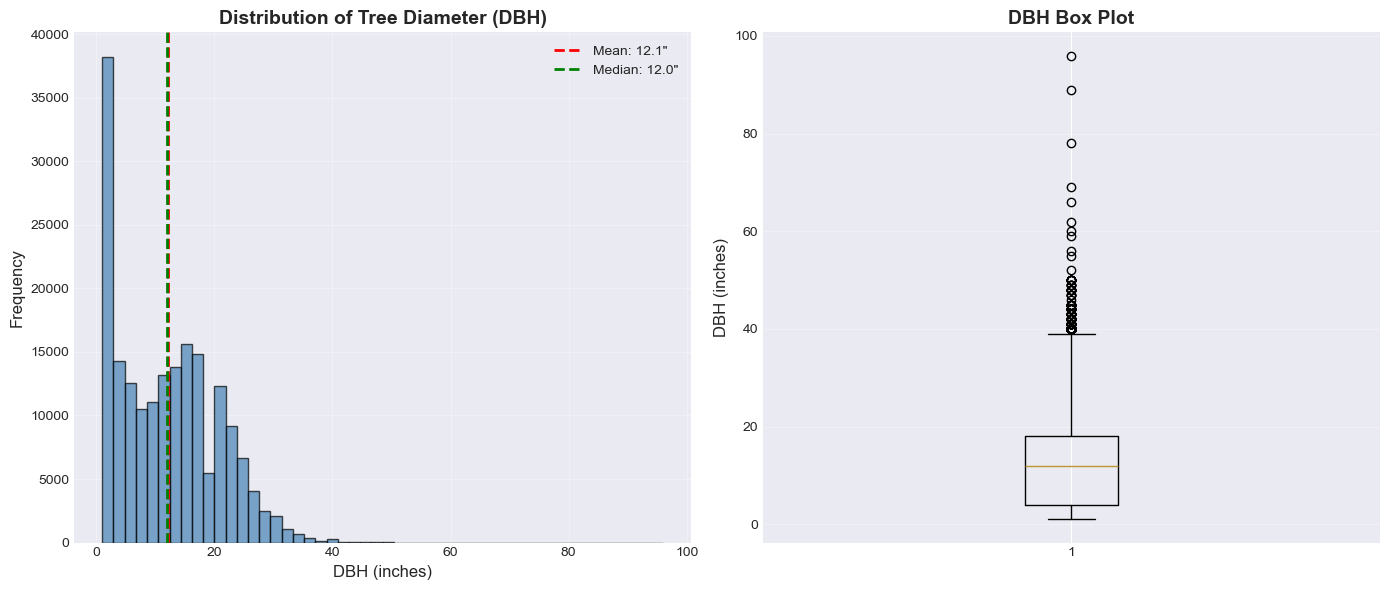


Trees with DBH > 30 inches (large/mature): 3,164 (1.7%)
Trees with DBH < 6 inches (young): 58,984 (31.1%)


In [47]:
# Analyze DBH (Diameter at Breast Height) distribution
print("=== DBH ANALYSIS ===")
print(f"DBH statistics:")
print(inventory_df['DBH'].describe())

# Remove outliers for better visualization (DBH > 0 and < 100 inches)
dbh_clean = inventory_df[(inventory_df['DBH'] > 0) & (inventory_df['DBH'] < 100)]['DBH']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
axes[0].hist(dbh_clean, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(dbh_clean.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {dbh_clean.mean():.1f}"')
axes[0].axvline(dbh_clean.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {dbh_clean.median():.1f}"')
axes[0].set_xlabel('DBH (inches)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Tree Diameter (DBH)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(dbh_clean, vert=True)
axes[1].set_ylabel('DBH (inches)', fontsize=12)
axes[1].set_title('DBH Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTrees with DBH > 30 inches (large/mature): {(inventory_df['DBH'] > 30).sum():,} ({(inventory_df['DBH'] > 30).sum() / len(inventory_df) * 100:.1f}%)")
print(f"Trees with DBH < 6 inches (young): {(inventory_df['DBH'] < 6).sum():,} ({(inventory_df['DBH'] < 6).sum() / len(inventory_df) * 100:.1f}%)")


In [48]:
# CRITICAL: Match service requests with inventory to identify which trees had failures
# This is key for understanding which species/characteristics correlate with failures

# Convert date columns
service_df['EnterDt'] = pd.to_datetime(service_df['EnterDt'], errors='coerce')
service_df['ResolvDt'] = pd.to_datetime(service_df['ResolvDt'], errors='coerce')

# Calculate resolution time
service_df['Resolution_Time_Hours'] = (service_df['ResolvDt'] - service_df['EnterDt']).dt.total_seconds() / 3600

# Extract location identifiers from service requests
# Service requests have Q (Quarter Section), A (Address), Street
# Inventory has Quarter Section, Address, Street

print("=== ATTEMPTING TO MATCH SERVICE REQUESTS WITH INVENTORY ===")
print(f"Service requests with valid Quarter Section: {service_df['Q'].notna().sum():,}")
print(f"Inventory trees with Quarter Section: {inventory_df['Quarter Section'].notna().sum():,}")

# Try to match on Quarter Section and Address
service_df['Q'] = service_df['Q'].astype(str).str.replace('.0', '', regex=False)
inventory_df['Quarter Section'] = inventory_df['Quarter Section'].astype(str).str.replace('.0', '', regex=False)

# IMPORTANT: Only match service requests with addresses that have exactly 1 tree
# This ensures we can confidently identify which specific tree had the failure
print("\n=== FILTERING FOR SINGLE-TREE ADDRESSES ===")
address_tree_counts = inventory_df.groupby(['Quarter Section', 'Address']).size().reset_index(name='Tree_Count')
single_tree_addresses = address_tree_counts[address_tree_counts['Tree_Count'] == 1]
print(f"Total unique addresses: {len(address_tree_counts):,}")
print(f"Addresses with exactly 1 tree: {len(single_tree_addresses):,} ({len(single_tree_addresses) / len(address_tree_counts) * 100:.1f}%)")
print(f"Addresses with multiple trees: {len(address_tree_counts[address_tree_counts['Tree_Count'] > 1]):,}")

# Filter inventory to only single-tree addresses
inventory_single_tree = inventory_df.merge(
    single_tree_addresses[['Quarter Section', 'Address']],
    on=['Quarter Section', 'Address'],
    how='inner'
)
print(f"\nTrees at single-tree addresses: {len(inventory_single_tree):,} out of {len(inventory_df):,} ({len(inventory_single_tree) / len(inventory_df) * 100:.1f}%)")

# Create a merged dataset - now this will be one-to-one or one-to-many (one tree can have multiple service requests)
# but NOT many-to-many (one service request will only match one tree)
merged = pd.merge(
    service_df,
    inventory_single_tree,
    left_on=['Q', 'A'],
    right_on=['Quarter Section', 'Address'],
    how='inner',
    suffixes=('_service', '_inventory')
)

# Calculate meaningful match statistics
unique_service_matched = merged['Rec#'].nunique()
unique_trees_matched = merged['Site ID'].nunique()
total_matches = len(merged)

print(f"\n=== MATCHING STATISTICS ===")
print(f"Total matched records: {total_matches:,}")
print(f"Unique service requests matched: {unique_service_matched:,} out of {len(service_df):,} ({unique_service_matched / len(service_df) * 100:.1f}%)")
print(f"Unique trees matched: {unique_trees_matched:,} out of {len(inventory_single_tree):,} ({unique_trees_matched / len(inventory_single_tree) * 100:.1f}%)")
print(f"\nNote: Only matching service requests with addresses that have exactly 1 tree.")
print(f"This ensures accurate failure-to-tree pairing. One tree can have multiple service requests.")
if unique_service_matched > 0:
    print(f"Average service requests per matched tree: {total_matches / unique_trees_matched:.2f}")

if len(merged) > 0:
    print(f"\nMatched data columns: {list(merged.columns)}")
    print(f"\nSample of matched data:")
    # Make sure Failure_Category is included if it exists
    display_cols = ['Service', 'Species', 'DBH', 'Condition']
    if 'Failure_Category' in merged.columns:
        display_cols.insert(1, 'Failure_Category')
    print(merged[display_cols].head(10))


=== ATTEMPTING TO MATCH SERVICE REQUESTS WITH INVENTORY ===
Service requests with valid Quarter Section: 64,614
Inventory trees with Quarter Section: 189,382

=== FILTERING FOR SINGLE-TREE ADDRESSES ===
Total unique addresses: 73,143
Addresses with exactly 1 tree: 32,141 (43.9%)
Addresses with multiple trees: 41,002

Trees at single-tree addresses: 32,141 out of 189,382 (17.0%)

=== MATCHING STATISTICS ===
Total matched records: 14,147
Unique service requests matched: 14,147 out of 64,614 (21.9%)
Unique trees matched: 7,940 out of 32,141 (24.7%)

Note: Only matching service requests with addresses that have exactly 1 tree.
This ensures accurate failure-to-tree pairing. One tree can have multiple service requests.
Average service requests per matched tree: 1.78

Matched data columns: ['Rec#', 'Name', 'Q', 'A', 'Street_service', 'Div', 'D', 'Service', 'EnterDt', 'PrintDt', 'ResolvDt', 'SanTruck', 'Rt', 'InspBy', 'Failure_Category', 'Resolution_Time_Hours', 'Site ID', 'Quarter Section', '

=== SPECIES FAILURE ANALYSIS ===

Top 20 species by total failure records:
Failure_Category                                    Branch Failure  Other  \
Species_Simple                                                              
MAPLE                                                         3448    289   
ASH                                                           3061    122   
HONEYLOCUST                                                    781     49   
LINDEN                                                         350     42   
ELM                                                            283     37   
OAK                                                            194     16   
HACKBERRY                                                      153     16   
LILAC                                                          167     18   
PEAR                                                           110      9   
COFFEETREE                                                      77      7   
C

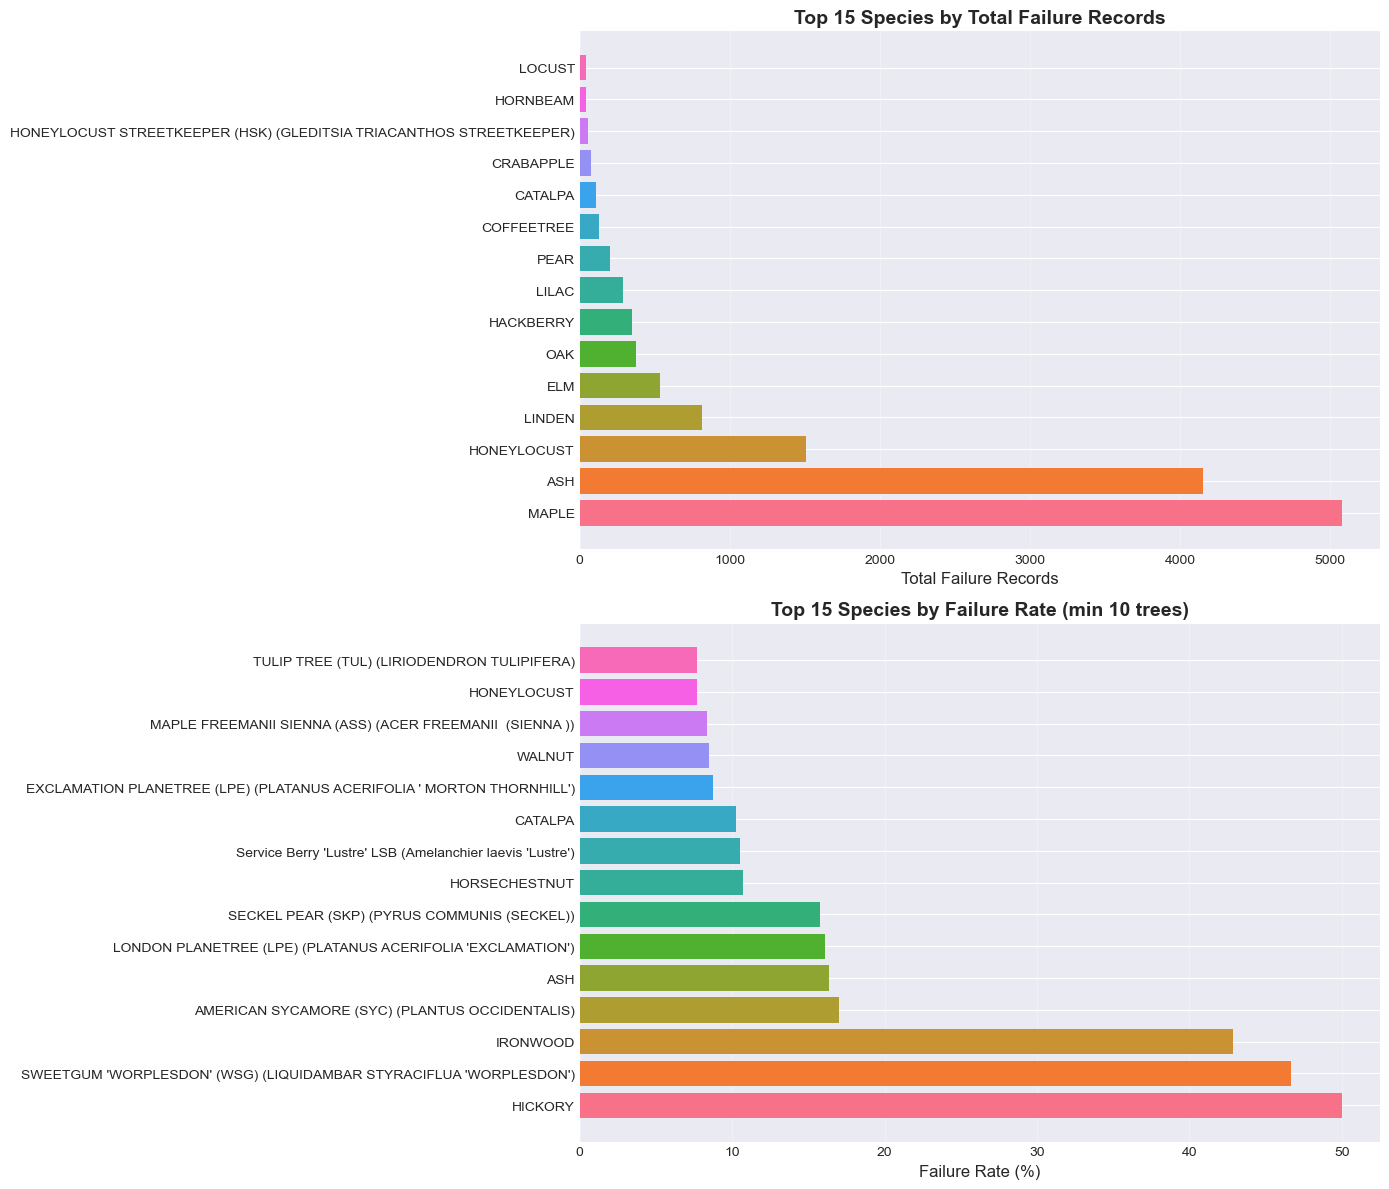

In [49]:
# Analyze species correlation with failures (if we have matches)
if len(merged) > 0:
    print("=== SPECIES FAILURE ANALYSIS ===")
    
    # Check if Failure_Category exists, if not create it
    if 'Failure_Category' not in merged.columns:
        print("Warning: Failure_Category not found in merged data. Creating it now...")
        # Re-apply the categorization function
        def categorize_failure(service_text):
            """Categorize service requests into failure types"""
            if pd.isna(service_text):
                return 'Unknown'
            service_lower = str(service_text).lower()
            
            # Branch failures
            if any(word in service_lower for word in ['branch', 'limb', 'broken branch', 'hanging branch']):
                return 'Branch Failure'
            # Tree failure/fall
            elif any(word in service_lower for word in ['tree down', 'tree fall', 'uprooted', 'fallen tree']):
                return 'Tree Failure'
            # Structural issues
            elif any(word in service_lower for word in ['split', 'crack', 'structural', 'hazard', 'dead']):
                return 'Structural Issue'
            # Root problems
            elif any(word in service_lower for word in ['root', 'heaving', 'lifting']):
                return 'Root Issue'
            # Pruning requests
            elif any(word in service_lower for word in ['prune', 'trim', 'trimming']):
                return 'Pruning Request'
            # Other
            else:
                return 'Other'
        
        merged['Failure_Category'] = merged['Service'].apply(categorize_failure)
    
    # Count failures by species
    species_failures = merged.groupby('Species_Simple')['Failure_Category'].value_counts().unstack(fill_value=0)
    species_failures['Total_Failures'] = species_failures.sum(axis=1)
    species_failures = species_failures.sort_values('Total_Failures', ascending=False)
    
    print("\nTop 20 species by total failure records:")
    print(species_failures.head(20))
    
    # Calculate failure rate per species
    # Count unique service requests per species (not total matches, since one request can match multiple trees)
    species_counts = inventory_df['Species_Simple'].value_counts()
    # Count unique service requests (Rec#) per species to avoid double counting
    species_failure_counts = merged.groupby('Species_Simple')['Rec#'].nunique()
    
    species_failure_rates = pd.DataFrame({
        'Total_Trees': species_counts,
        'Unique_Service_Requests': species_failure_counts
    }).fillna(0)
    species_failure_rates['Failure_Rate'] = (species_failure_rates['Unique_Service_Requests'] / 
                                             species_failure_rates['Total_Trees'] * 100)
    species_failure_rates = species_failure_rates[species_failure_rates['Total_Trees'] >= 10].sort_values('Failure_Rate', ascending=False)
    
    print("\n=== SPECIES FAILURE RATES (min 10 trees) ===")
    print("Note: Failure rate = unique service requests / total trees of that species")
    print(species_failure_rates.head(20))
    
    # Visualize
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Top species by failure count (total records)
    top_failures = species_failures.head(15)
    axes[0].barh(range(len(top_failures)), top_failures['Total_Failures'].values,
                 color=sns.color_palette("husl", len(top_failures)))
    axes[0].set_yticks(range(len(top_failures)))
    axes[0].set_yticklabels(top_failures.index, fontsize=10)
    axes[0].set_xlabel('Total Failure Records', fontsize=12)
    axes[0].set_title('Top 15 Species by Total Failure Records', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Top species by failure rate
    top_rates = species_failure_rates.head(15)
    axes[1].barh(range(len(top_rates)), top_rates['Failure_Rate'].values,
                color=sns.color_palette("husl", len(top_rates)))
    axes[1].set_yticks(range(len(top_rates)))
    axes[1].set_yticklabels(top_rates.index, fontsize=10)
    axes[1].set_xlabel('Failure Rate (%)', fontsize=12)
    axes[1].set_title('Top 15 Species by Failure Rate (min 10 trees)', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No matches found. Will analyze by location/district instead.")


=== CONDITION VS FAILURES ===
Service     Branches / bushes blocking sign  \
Condition                                     
Dead                                      0   
Excellent                                 1   
Fair                                     28   
Good                                     70   
Poor                                      0   
Unassigned                                2   

Service     Broken Branch Down blocking driveway  \
Condition                                          
Dead                                           0   
Excellent                                      0   
Fair                                          65   
Good                                         138   
Poor                                           8   
Unassigned                                     7   

Service     Broken Branch Down blocking sidewalk  \
Condition                                          
Dead                                           0   
Excellent           

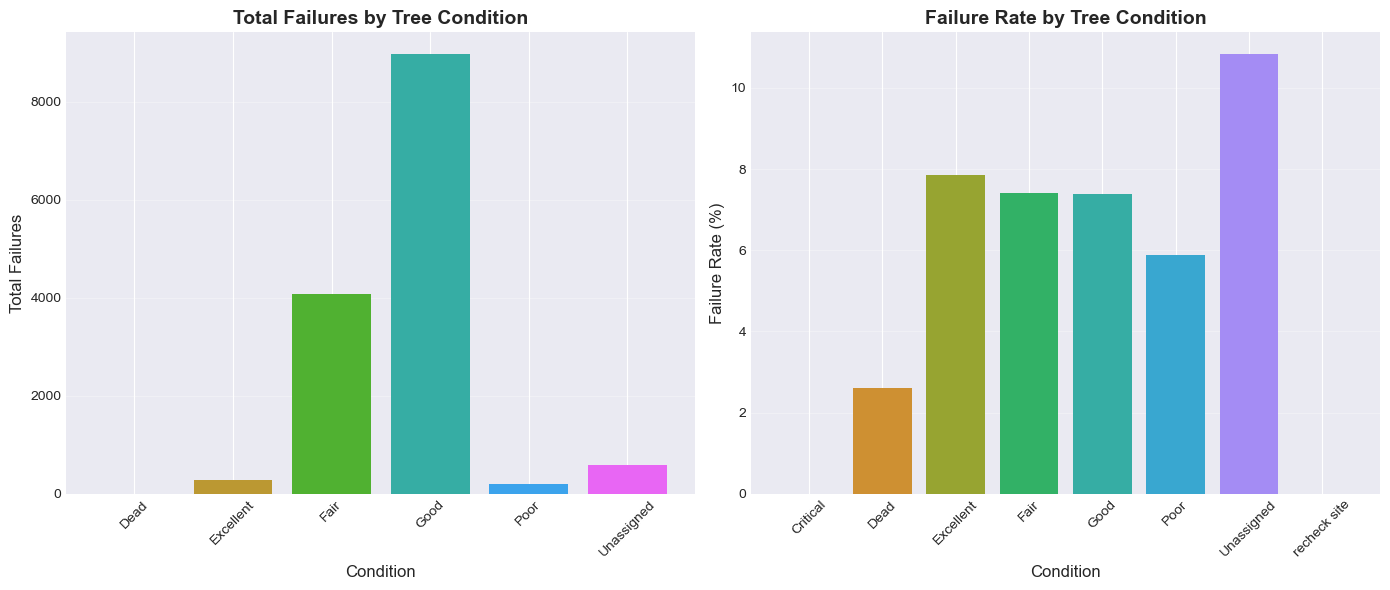

In [50]:
# Analyze condition vs failures
if len(merged) > 0:
    print("=== CONDITION VS FAILURES ===")
    condition_failures = merged.groupby('Condition')['Service'].value_counts().unstack(fill_value=0)
    condition_failures['Total'] = condition_failures.sum(axis=1)
    print(condition_failures)
    
    # Calculate failure rates by condition
    condition_counts = inventory_df['Condition'].value_counts()
    condition_failure_counts = merged['Condition'].value_counts()
    condition_rates = pd.DataFrame({
        'Total_Trees': condition_counts,
        'Total_Failures': condition_failure_counts
    }).fillna(0)
    condition_rates['Failure_Rate'] = (condition_rates['Total_Failures'] / 
                                       condition_rates['Total_Trees'] * 100)
    print("\n=== FAILURE RATES BY CONDITION ===")
    print(condition_rates.sort_values('Failure_Rate', ascending=False))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Failure count by condition
    axes[0].bar(condition_failures.index, condition_failures['Total'].values,
               color=sns.color_palette("husl", len(condition_failures)))
    axes[0].set_xlabel('Condition', fontsize=12)
    axes[0].set_ylabel('Total Failures', fontsize=12)
    axes[0].set_title('Total Failures by Tree Condition', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Failure rate by condition
    axes[1].bar(condition_rates.index, condition_rates['Failure_Rate'].values,
               color=sns.color_palette("husl", len(condition_rates)))
    axes[1].set_xlabel('Condition', fontsize=12)
    axes[1].set_ylabel('Failure Rate (%)', fontsize=12)
    axes[1].set_title('Failure Rate by Tree Condition', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


=== DBH VS FAILURES ===
Failure_Category  Branch Failure  Other  Pruning Request  Structural Issue  \
DBH_Bin                                                                      
0-6"                        1919    238              734               119   
6-12"                        719     61              504                22   
12-18"                      1570    117              805                49   
18-24"                      2261    152              803                43   
24-30"                      1606     75              496                16   
30+"                         943     24              220                 1   

Failure_Category  Tree Failure  Total  
DBH_Bin                                
0-6"                       286   3296  
6-12"                       77   1383  
12-18"                     129   2670  
18-24"                      95   3354  
24-30"                      38   2231  
30+"                        19   1207  

=== FAILURE RATES BY DBH BIN =

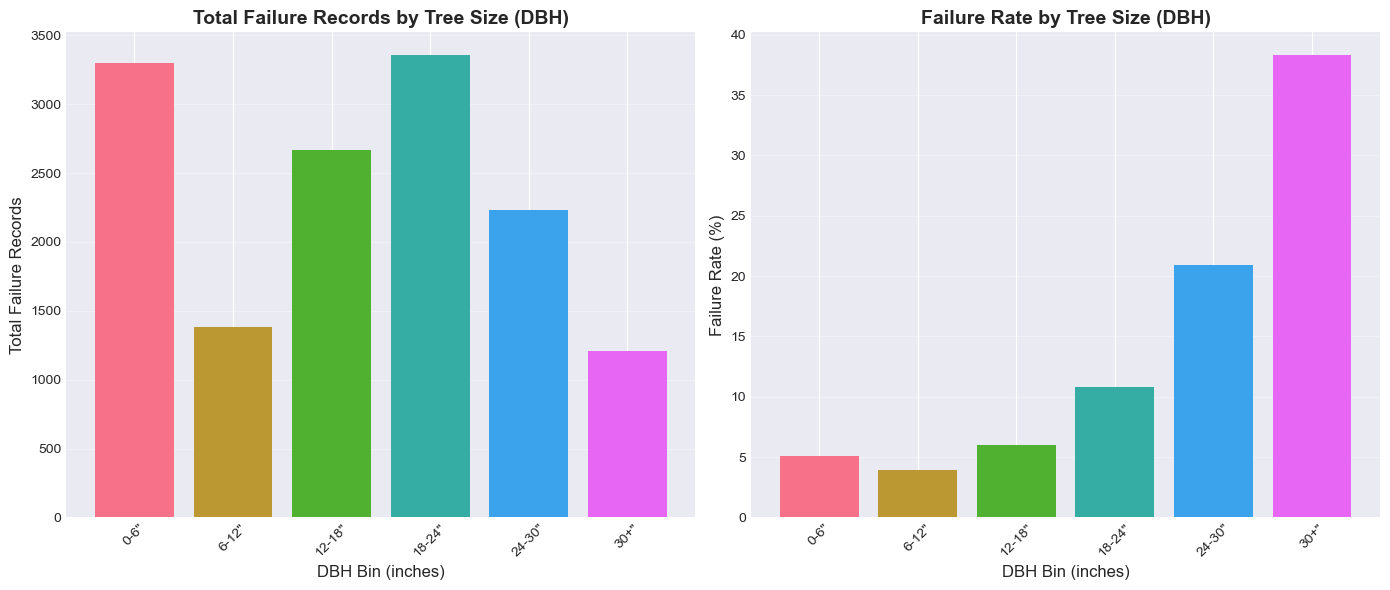

In [51]:
# Analyze DBH vs failures
if len(merged) > 0:
    print("=== DBH VS FAILURES ===")
    
    # Ensure Failure_Category exists
    if 'Failure_Category' not in merged.columns:
        print("Warning: Failure_Category not found. Creating it...")
        def categorize_failure(service_text):
            if pd.isna(service_text):
                return 'Unknown'
            service_lower = str(service_text).lower()
            if any(word in service_lower for word in ['branch', 'limb', 'broken branch', 'hanging branch']):
                return 'Branch Failure'
            elif any(word in service_lower for word in ['tree down', 'tree fall', 'uprooted', 'fallen tree']):
                return 'Tree Failure'
            elif any(word in service_lower for word in ['split', 'crack', 'structural', 'hazard', 'dead']):
                return 'Structural Issue'
            elif any(word in service_lower for word in ['root', 'heaving', 'lifting']):
                return 'Root Issue'
            elif any(word in service_lower for word in ['prune', 'trim', 'trimming']):
                return 'Pruning Request'
            else:
                return 'Other'
        merged['Failure_Category'] = merged['Service'].apply(categorize_failure)
    
    # Create DBH bins
    merged['DBH_Bin'] = pd.cut(merged['DBH'], 
                               bins=[0, 6, 12, 18, 24, 30, 100],
                               labels=['0-6"', '6-12"', '12-18"', '18-24"', '24-30"', '30+"'])
    
    dbh_failures = merged.groupby('DBH_Bin')['Failure_Category'].value_counts().unstack(fill_value=0)
    dbh_failures['Total'] = dbh_failures.sum(axis=1)
    print(dbh_failures)
    
    # Calculate failure rates by DBH bin (using unique service requests)
    inventory_df['DBH_Bin'] = pd.cut(inventory_df['DBH'],
                                     bins=[0, 6, 12, 18, 24, 30, 100],
                                     labels=['0-6"', '6-12"', '12-18"', '18-24"', '24-30"', '30+"'])
    
    dbh_counts = inventory_df['DBH_Bin'].value_counts().sort_index()
    dbh_failure_counts = merged.groupby('DBH_Bin')['Rec#'].nunique().sort_index()  # Unique requests
    dbh_rates = pd.DataFrame({
        'Total_Trees': dbh_counts,
        'Unique_Service_Requests': dbh_failure_counts
    }).fillna(0)
    dbh_rates['Failure_Rate'] = (dbh_rates['Unique_Service_Requests'] / 
                                 dbh_rates['Total_Trees'] * 100)
    print("\n=== FAILURE RATES BY DBH BIN ===")
    print("Note: Failure rate = unique service requests / total trees in that DBH bin")
    print(dbh_rates)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Failure count by DBH (total records)
    axes[0].bar(dbh_failures.index.astype(str), dbh_failures['Total'].values,
               color=sns.color_palette("husl", len(dbh_failures)))
    axes[0].set_xlabel('DBH Bin (inches)', fontsize=12)
    axes[0].set_ylabel('Total Failure Records', fontsize=12)
    axes[0].set_title('Total Failure Records by Tree Size (DBH)', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Failure rate by DBH
    axes[1].bar(dbh_rates.index.astype(str), dbh_rates['Failure_Rate'].values,
               color=sns.color_palette("husl", len(dbh_rates)))
    axes[1].set_xlabel('DBH Bin (inches)', fontsize=12)
    axes[1].set_ylabel('Failure Rate (%)', fontsize=12)
    axes[1].set_title('Failure Rate by Tree Size (DBH)', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


=== DISTRICT ANALYSIS ===
Service requests by district (from inventory matching):
Failure_Category  Branch Failure  Other  Pruning Request  Structural Issue  \
District                                                                     
Central                     2347    230             1226                85   
North                       3165    180              983                78   
South                       3509    258             1355                87   

Failure_Category  Tree Failure  Total  
District                               
Central                    219   4107  
North                      206   4612  
South                      219   5428  

=== FAILURE RATES BY DISTRICT ===
Note: Failure rate = unique service requests / total trees in that district
          Total_Trees  Unique_Service_Requests  Failure_Rate
District                                                    
South           60278                     5428      9.004944
Central         60491            

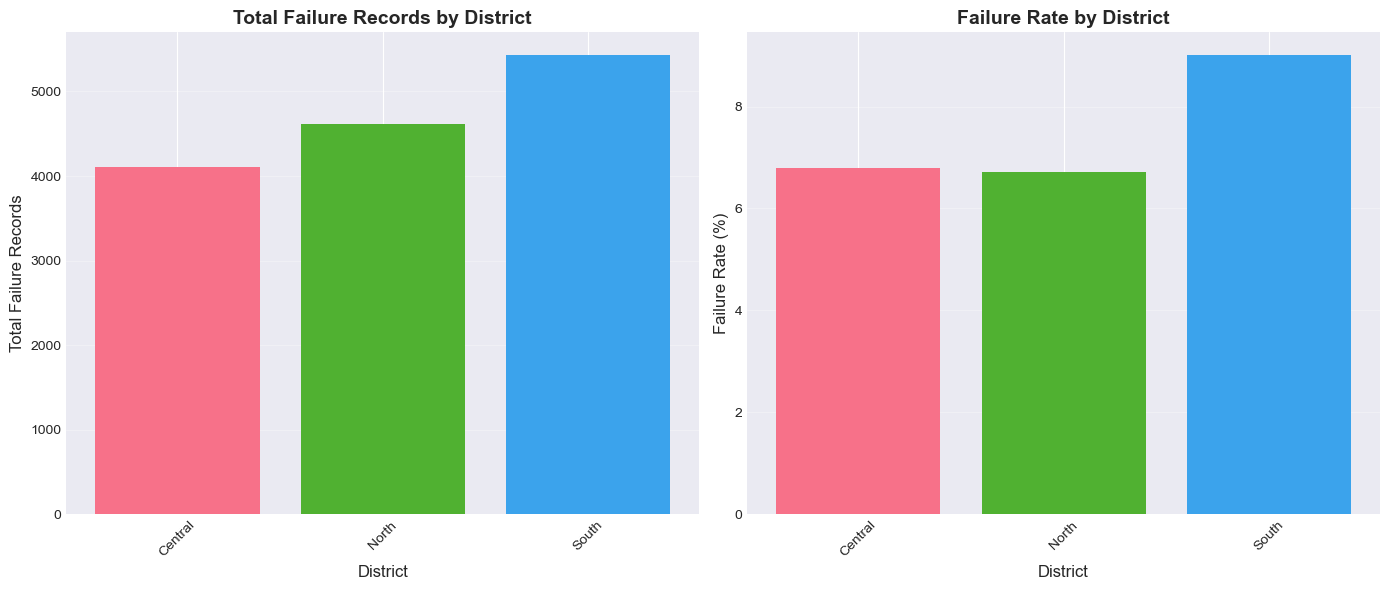


=== INVENTORY BY DISTRICT ===
District
North      68613
Central    60491
South      60278
Name: count, dtype: int64


In [52]:
# Analyze district patterns
print("=== DISTRICT ANALYSIS ===")
print("Service requests by district (from inventory matching):")
if len(merged) > 0:
    # Ensure Failure_Category exists
    if 'Failure_Category' not in merged.columns:
        print("Warning: Failure_Category not found. Creating it...")
        def categorize_failure(service_text):
            if pd.isna(service_text):
                return 'Unknown'
            service_lower = str(service_text).lower()
            if any(word in service_lower for word in ['branch', 'limb', 'broken branch', 'hanging branch']):
                return 'Branch Failure'
            elif any(word in service_lower for word in ['tree down', 'tree fall', 'uprooted', 'fallen tree']):
                return 'Tree Failure'
            elif any(word in service_lower for word in ['split', 'crack', 'structural', 'hazard', 'dead']):
                return 'Structural Issue'
            elif any(word in service_lower for word in ['root', 'heaving', 'lifting']):
                return 'Root Issue'
            elif any(word in service_lower for word in ['prune', 'trim', 'trimming']):
                return 'Pruning Request'
            else:
                return 'Other'
        merged['Failure_Category'] = merged['Service'].apply(categorize_failure)
    
    district_failures = merged.groupby('District')['Failure_Category'].value_counts().unstack(fill_value=0)
    district_failures['Total'] = district_failures.sum(axis=1)
    print(district_failures)
    
    # Calculate failure rates by district (using unique service requests)
    district_counts = inventory_df['District'].value_counts()
    district_failure_counts = merged.groupby('District')['Rec#'].nunique()  # Unique requests
    district_rates = pd.DataFrame({
        'Total_Trees': district_counts,
        'Unique_Service_Requests': district_failure_counts
    }).fillna(0)
    district_rates['Failure_Rate'] = (district_rates['Unique_Service_Requests'] / 
                                      district_rates['Total_Trees'] * 100)
    print("\n=== FAILURE RATES BY DISTRICT ===")
    print("Note: Failure rate = unique service requests / total trees in that district")
    print(district_rates.sort_values('Failure_Rate', ascending=False))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].bar(district_failures.index, district_failures['Total'].values,
               color=sns.color_palette("husl", len(district_failures)))
    axes[0].set_xlabel('District', fontsize=12)
    axes[0].set_ylabel('Total Failure Records', fontsize=12)
    axes[0].set_title('Total Failure Records by District', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    axes[1].bar(district_rates.index, district_rates['Failure_Rate'].values,
               color=sns.color_palette("husl", len(district_rates)))
    axes[1].set_xlabel('District', fontsize=12)
    axes[1].set_ylabel('Failure Rate (%)', fontsize=12)
    axes[1].set_title('Failure Rate by District', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n=== INVENTORY BY DISTRICT ===")
print(inventory_df['District'].value_counts())


=== TEMPORAL ANALYSIS ===
Failures by year:
Failure_Category  Branch Failure  Other  Pruning Request  Structural Issue  \
Year                                                                         
2016                         521     29              266                18   
2017                         612     22              335                23   
2018                         623     20              216                20   
2019                         979     23              333                27   
2020                         925     58              359                32   
2021                        1175    120              323                42   
2022                         749     84              370                21   
2023                        1516    140              421                21   
2024                         970     77              450                31   
2025                         951     95              491                15   

Failure_Category  T

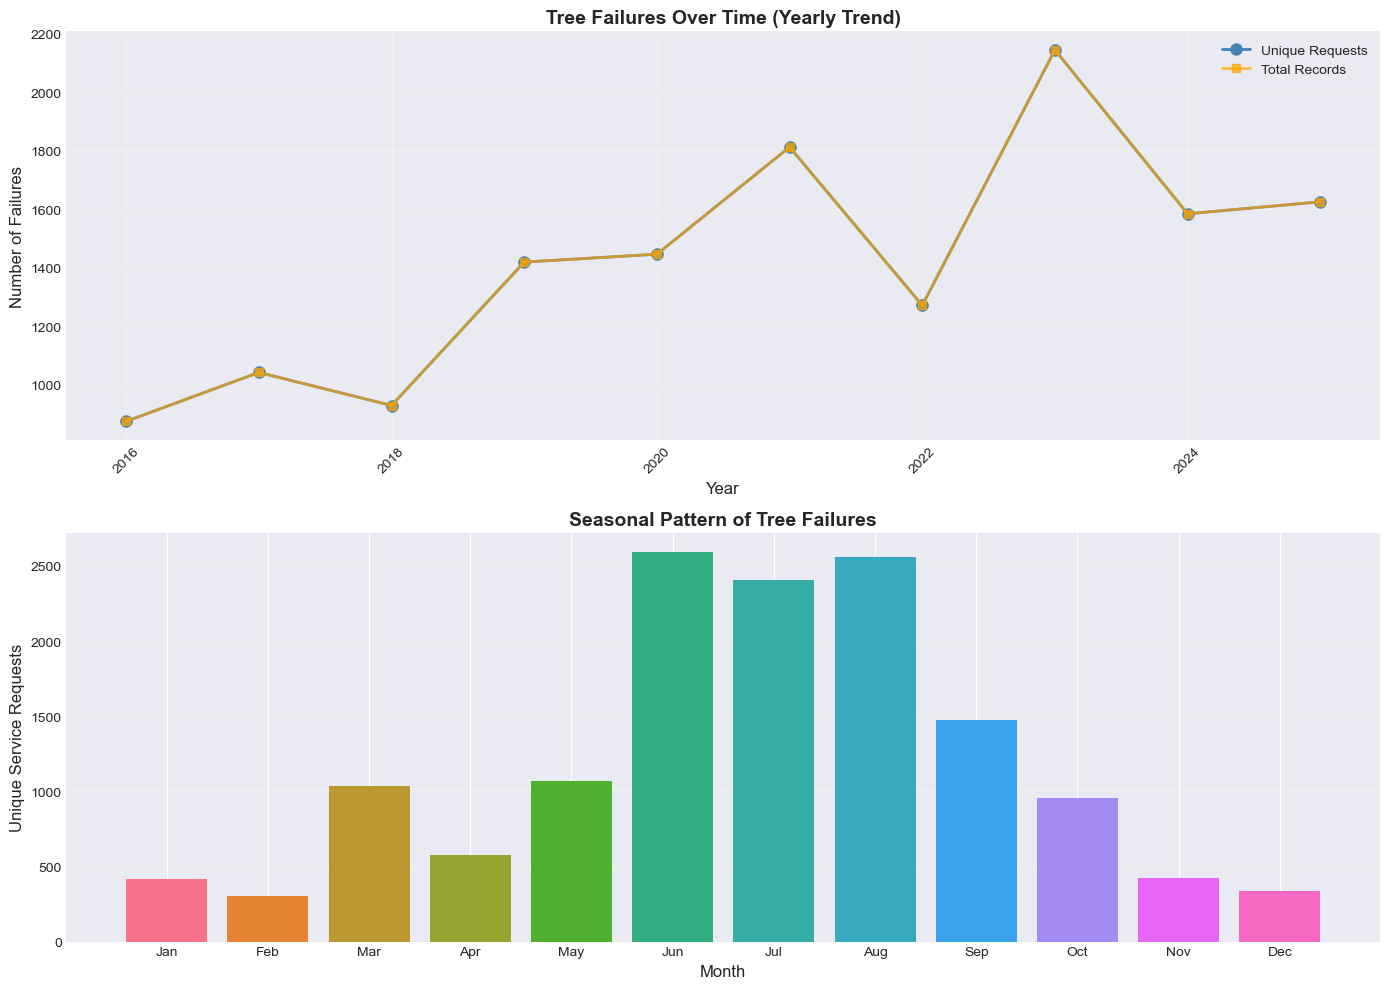

In [53]:
# Time-based analysis of failures
print("=== TEMPORAL ANALYSIS ===")
if len(merged) > 0:
    # Ensure Failure_Category exists
    if 'Failure_Category' not in merged.columns:
        print("Warning: Failure_Category not found. Creating it...")
        def categorize_failure(service_text):
            if pd.isna(service_text):
                return 'Unknown'
            service_lower = str(service_text).lower()
            if any(word in service_lower for word in ['branch', 'limb', 'broken branch', 'hanging branch']):
                return 'Branch Failure'
            elif any(word in service_lower for word in ['tree down', 'tree fall', 'uprooted', 'fallen tree']):
                return 'Tree Failure'
            elif any(word in service_lower for word in ['split', 'crack', 'structural', 'hazard', 'dead']):
                return 'Structural Issue'
            elif any(word in service_lower for word in ['root', 'heaving', 'lifting']):
                return 'Root Issue'
            elif any(word in service_lower for word in ['prune', 'trim', 'trimming']):
                return 'Pruning Request'
            else:
                return 'Other'
        merged['Failure_Category'] = merged['Service'].apply(categorize_failure)
    
    merged['Year'] = merged['EnterDt'].dt.year
    merged['Month'] = merged['EnterDt'].dt.month
    
    # Failures by year (using unique service requests to avoid double counting)
    yearly_failures = merged.groupby('Year')['Failure_Category'].value_counts().unstack(fill_value=0)
    yearly_failures['Total_Records'] = yearly_failures.sum(axis=1)
    yearly_failures['Unique_Requests'] = merged.groupby('Year')['Rec#'].nunique()
    print("Failures by year:")
    print(yearly_failures)
    
    # Failures by month (seasonal patterns)
    monthly_failures = merged.groupby('Month')['Failure_Category'].value_counts().unstack(fill_value=0)
    monthly_failures['Total_Records'] = monthly_failures.sum(axis=1)
    monthly_failures['Unique_Requests'] = merged.groupby('Month')['Rec#'].nunique()
    print("\nFailures by month (seasonal patterns):")
    print(monthly_failures)
    
    # Visualize
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Yearly trends (using unique requests)
    axes[0].plot(yearly_failures.index, yearly_failures['Unique_Requests'].values, 
                marker='o', linewidth=2, markersize=8, color='steelblue', label='Unique Requests')
    axes[0].plot(yearly_failures.index, yearly_failures['Total_Records'].values, 
                marker='s', linewidth=2, markersize=6, color='orange', alpha=0.7, label='Total Records')
    axes[0].set_xlabel('Year', fontsize=12)
    axes[0].set_ylabel('Number of Failures', fontsize=12)
    axes[0].set_title('Tree Failures Over Time (Yearly Trend)', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Monthly patterns (using unique requests)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axes[1].bar(monthly_failures.index, monthly_failures['Unique_Requests'].values,
               color=sns.color_palette("husl", len(monthly_failures)))
    axes[1].set_xlabel('Month', fontsize=12)
    axes[1].set_ylabel('Unique Service Requests', fontsize=12)
    axes[1].set_title('Seasonal Pattern of Tree Failures', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(1, 13))
    axes[1].set_xticklabels(month_names)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [54]:
# Create a comprehensive risk score dataset for prioritization model
print("=== CREATING PRIORITIZATION FEATURES ===")

# Start with inventory as base
prioritization_df = inventory_df.copy()

# Filter out trees with DBH = 0 (incomplete data coverage)
print(f"Original inventory size: {len(prioritization_df):,} trees")
prioritization_df = prioritization_df[prioritization_df['DBH'] > 0].copy()
print(f"After filtering DBH > 0: {len(prioritization_df):,} trees")
print(f"Removed {len(inventory_df) - len(prioritization_df):,} trees with DBH = 0")

# Add failure indicators based on matched data
if len(merged) > 0:
    # Ensure Failure_Category exists in merged
    if 'Failure_Category' not in merged.columns:
        print("Creating Failure_Category in merged data...")
        def categorize_failure(service_text):
            if pd.isna(service_text):
                return 'Unknown'
            service_lower = str(service_text).lower()
            if any(word in service_lower for word in ['branch', 'limb', 'broken branch', 'hanging branch']):
                return 'Branch Failure'
            elif any(word in service_lower for word in ['tree down', 'tree fall', 'uprooted', 'fallen tree']):
                return 'Tree Failure'
            elif any(word in service_lower for word in ['split', 'crack', 'structural', 'hazard', 'dead']):
                return 'Structural Issue'
            elif any(word in service_lower for word in ['root', 'heaving', 'lifting']):
                return 'Root Issue'
            elif any(word in service_lower for word in ['prune', 'trim', 'trimming']):
                return 'Pruning Request'
            else:
                return 'Other'
        merged['Failure_Category'] = merged['Service'].apply(categorize_failure)
    
    # Count unique service requests per tree (not total matches, to avoid double counting)
    tree_failures = merged.groupby('Site ID').agg({
        'Rec#': 'nunique',  # Count unique service requests
        'Service': lambda x: ', '.join(x.astype(str).unique()[:3])  # First 3 service types
    }).rename(columns={'Rec#': 'Failure_Count', 'Service': 'Failure_Types'})
    
    prioritization_df = prioritization_df.merge(
        tree_failures,
        left_on='Site ID',
        right_index=True,
        how='left'
    )
    prioritization_df['Failure_Count'] = prioritization_df['Failure_Count'].fillna(0).astype(int)
    prioritization_df['Has_Failure'] = (prioritization_df['Failure_Count'] > 0).astype(int)
else:
    prioritization_df['Failure_Count'] = 0
    prioritization_df['Has_Failure'] = 0
    prioritization_df['Failure_Types'] = ''

# Add species-level risk scores (based on failure rates)
if len(merged) > 0:
    # Recreate species_failure_rates if not already created (in case cell 12 wasn't run)
    if 'species_failure_rates' not in locals() and 'species_failure_rates' not in globals():
        print("Recreating species_failure_rates...")
        species_counts = inventory_df['Species_Simple'].value_counts()
        species_failure_counts = merged.groupby('Species_Simple')['Rec#'].nunique()
        species_failure_rates = pd.DataFrame({
            'Total_Trees': species_counts,
            'Unique_Service_Requests': species_failure_counts
        }).fillna(0)
        species_failure_rates['Failure_Rate'] = (species_failure_rates['Unique_Service_Requests'] / 
                                                 species_failure_rates['Total_Trees'] * 100)
    
    species_risk = species_failure_rates[['Failure_Rate']].copy()
    
    # Use qcut with error handling - if duplicates cause fewer bins, handle dynamically
    try:
        # Try qcut first (quantile-based) without labels to see how many bins we get
        temp_cut = pd.qcut(
            species_risk['Failure_Rate'], 
            q=5, 
            duplicates='drop'
        )
        num_bins = len(temp_cut.cat.categories)
        
        # Create labels based on actual number of bins
        label_map = {
            1: ['Medium'],
            2: ['Low', 'High'],
            3: ['Low', 'Medium', 'High'],
            4: ['Very Low', 'Low', 'High', 'Very High'],
            5: ['Very Low', 'Low', 'Medium', 'High', 'Very High']
        }
        labels_to_use = label_map.get(num_bins, list(range(num_bins)))
        
        # Now do the cut with appropriate labels
        species_risk['Species_Risk_Score'] = pd.qcut(
            species_risk['Failure_Rate'], 
            q=5, 
            labels=labels_to_use,
            duplicates='drop'
        )
    except ValueError as e:
        # If qcut still fails, use cut with percentile-based bins
        print(f"Warning: qcut failed ({str(e)}). Using percentile-based cut instead.")
        failure_rates = species_risk['Failure_Rate'].dropna()
        if len(failure_rates) == 0:
            species_risk['Species_Risk_Score'] = pd.Series(['Unknown'] * len(species_risk), dtype=str)
        elif failure_rates.nunique() == 1:
            # All values are the same
            species_risk['Species_Risk_Score'] = pd.Series(['Medium'] * len(species_risk), dtype=str)
        else:
            # Use percentiles to create bins
            percentiles = [0, 20, 40, 60, 80, 100]
            bins = np.percentile(failure_rates, percentiles)
            # Remove duplicate bin edges and ensure min/max
            bins = sorted(list(set(bins)))
            if bins[0] != failure_rates.min():
                bins.insert(0, failure_rates.min())
            if bins[-1] != failure_rates.max():
                bins.append(failure_rates.max())
            bins = sorted(list(set(bins)))
            
            num_bins = len(bins) - 1
            label_map = {
                1: ['Medium'],
                2: ['Low', 'High'],
                3: ['Low', 'Medium', 'High'],
                4: ['Very Low', 'Low', 'High', 'Very High'],
                5: ['Very Low', 'Low', 'Medium', 'High', 'Very High']
            }
            labels_to_use = label_map.get(num_bins, [f'Bin_{i+1}' for i in range(num_bins)])
            
            species_risk['Species_Risk_Score'] = pd.cut(
                species_risk['Failure_Rate'],
                bins=bins,
                labels=labels_to_use,
                include_lowest=True,
                duplicates='drop'
            )
    
    # Convert to string to avoid categorical issues when filling NaN (handles all code paths)
    species_risk['Species_Risk_Score'] = species_risk['Species_Risk_Score'].astype(str)
    
    prioritization_df = prioritization_df.merge(
        species_risk[['Species_Risk_Score']],
        left_on='Species_Simple',
        right_index=True,
        how='left'
    )
    # Convert to string after merge (in case merge preserves categorical dtype)
    prioritization_df['Species_Risk_Score'] = prioritization_df['Species_Risk_Score'].astype(str)
    prioritization_df['Species_Risk_Score'] = prioritization_df['Species_Risk_Score'].fillna('Unknown')
else:
    prioritization_df['Species_Risk_Score'] = 'Unknown'

# Add condition risk score
condition_risk_map = {
    'Excellent': 1,
    'Good': 2,
    'Fair': 3,
    'Poor': 4,
    'Dead': 5,
    'Critical': 5
}
prioritization_df['Condition_Risk_Score'] = prioritization_df['Condition'].map(condition_risk_map).fillna(3)

# Add DBH risk score (larger trees = higher risk)
prioritization_df['DBH_Risk_Score'] = pd.cut(
    prioritization_df['DBH'],
    bins=[0, 6, 12, 18, 24, 30, 200],
    labels=[1, 2, 3, 4, 5, 6]
).astype(float).fillna(3)

# Calculate age (if inventory date available)
prioritization_df['Inventory Date'] = pd.to_datetime(prioritization_df['Inventory Date'], errors='coerce')
prioritization_df['Years_Since_Inventory'] = (pd.Timestamp.now() - prioritization_df['Inventory Date']).dt.days / 365.25
prioritization_df['Years_Since_Inventory'] = prioritization_df['Years_Since_Inventory'].fillna(0)

# Create composite risk score
prioritization_df['Composite_Risk_Score'] = (
    prioritization_df['Condition_Risk_Score'] * 0.3 +
    prioritization_df['DBH_Risk_Score'] * 0.2 +
    prioritization_df['Failure_Count'] * 2.0 +  # High weight on actual failures
    (prioritization_df['Years_Since_Inventory'] > 5).astype(int) * 1.0
)

# Normalize risk score to 0-100 scale
prioritization_df['Risk_Score_Normalized'] = (
    (prioritization_df['Composite_Risk_Score'] - prioritization_df['Composite_Risk_Score'].min()) /
    (prioritization_df['Composite_Risk_Score'].max() - prioritization_df['Composite_Risk_Score'].min()) * 100
)

print(f"Created prioritization dataset with {len(prioritization_df):,} trees")
print(f"\nRisk score statistics:")
print(prioritization_df['Risk_Score_Normalized'].describe())

print(f"\nTop 20 highest risk trees:")
top_risk = prioritization_df.nlargest(20, 'Risk_Score_Normalized')[
    ['Site ID', 'Species_Simple', 'DBH', 'Condition', 'Failure_Count', 'Risk_Score_Normalized']
]
print(top_risk)


=== CREATING PRIORITIZATION FEATURES ===
Original inventory size: 189,382 trees
After filtering DBH > 0: 189,103 trees
Removed 279 trees with DBH = 0
Created prioritization dataset with 189,103 trees

Risk score statistics:
count    189103.000000
mean          3.067490
std           1.973439
min           0.000000
25%           2.325581
50%           3.041145
75%           3.577818
max         100.000000
Name: Risk_Score_Normalized, dtype: float64

Top 20 highest risk trees:
        Site ID                                  Species_Simple   DBH  \
32916    135668                                             ASH  24.0   
24597    130473                                             ASH  29.0   
145152   172471                                             ASH  24.0   
94130    126849                                             ASH  30.0   
114399   173501                                             ASH  18.0   
29109     13265                                             ASH  37.0   
164277   

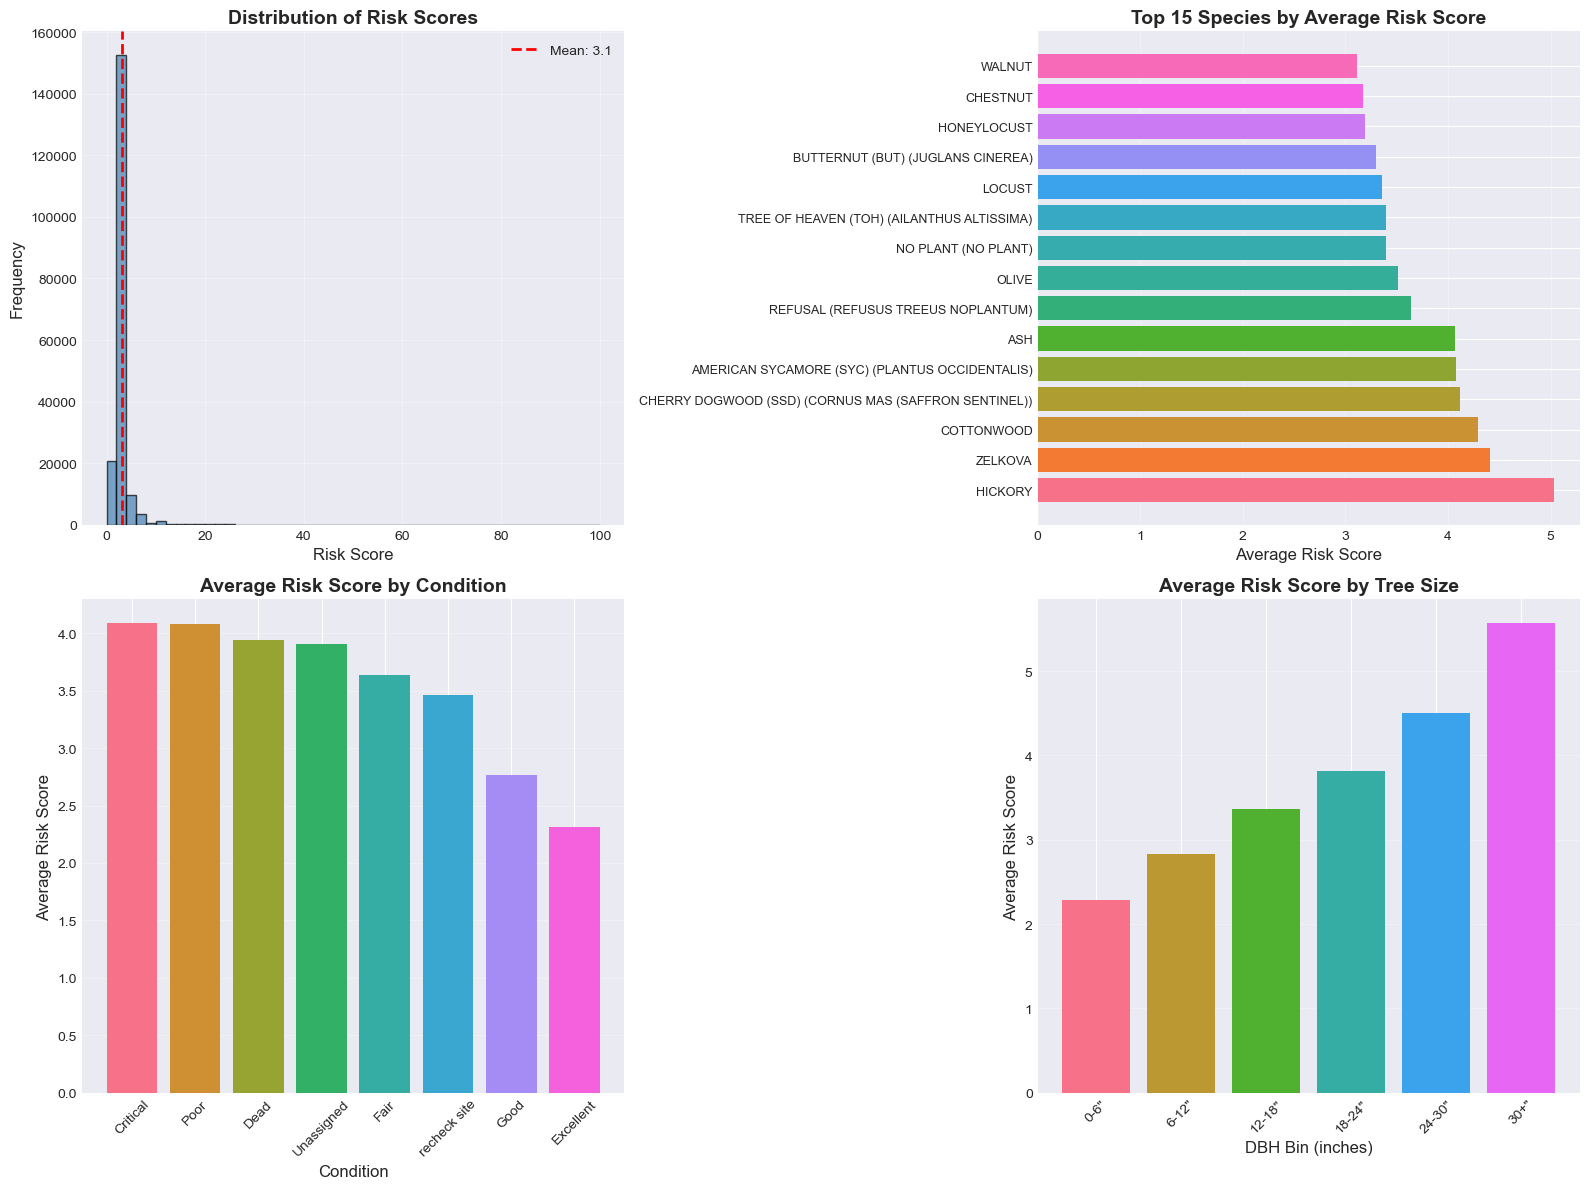

In [ ]:
# Visualize risk score distribution and top risk factors
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Risk score distribution
axes[0, 0].hist(prioritization_df['Risk_Score_Normalized'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(prioritization_df['Risk_Score_Normalized'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {prioritization_df["Risk_Score_Normalized"].mean():.1f}')
axes[0, 0].set_xlabel('Risk Score', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Risk Scores', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Risk by species (top 15)
if len(merged) > 0:
    species_risk_avg = prioritization_df.groupby('Species_Simple')['Risk_Score_Normalized'].mean().sort_values(ascending=False).head(15)
    axes[0, 1].barh(range(len(species_risk_avg)), species_risk_avg.values,
                    color=sns.color_palette("husl", len(species_risk_avg)))
    axes[0, 1].set_yticks(range(len(species_risk_avg)))
    axes[0, 1].set_yticklabels(species_risk_avg.index, fontsize=9)
    axes[0, 1].set_xlabel('Average Risk Score', fontsize=12)
    axes[0, 1].set_title('Top 15 Species by Average Risk Score', fontsize=14, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)

# Risk by condition
condition_risk_avg = prioritization_df.groupby('Condition')['Risk_Score_Normalized'].mean().sort_values(ascending=False)
axes[1, 0].bar(condition_risk_avg.index, condition_risk_avg.values,
               color=sns.color_palette("husl", len(condition_risk_avg)))
axes[1, 0].set_xlabel('Condition', fontsize=12)
axes[1, 0].set_ylabel('Average Risk Score', fontsize=12)
axes[1, 0].set_title('Average Risk Score by Condition', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Risk by DBH bin
prioritization_df['DBH_Bin'] = pd.cut(prioritization_df['DBH'],
                                      bins=[0, 6, 12, 18, 24, 30, 200],
                                      labels=['0-6"', '6-12"', '12-18"', '18-24"', '24-30"', '30+"'])
dbh_risk_avg = prioritization_df.groupby('DBH_Bin')['Risk_Score_Normalized'].mean()
axes[1, 1].bar(dbh_risk_avg.index.astype(str), dbh_risk_avg.values,
               color=sns.color_palette("husl", len(dbh_risk_avg)))
axes[1, 1].set_xlabel('DBH Bin (inches)', fontsize=12)
axes[1, 1].set_ylabel('Average Risk Score', fontsize=12)
axes[1, 1].set_title('Average Risk Score by Tree Size', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


=== FEATURE CORRELATION ANALYSIS ===


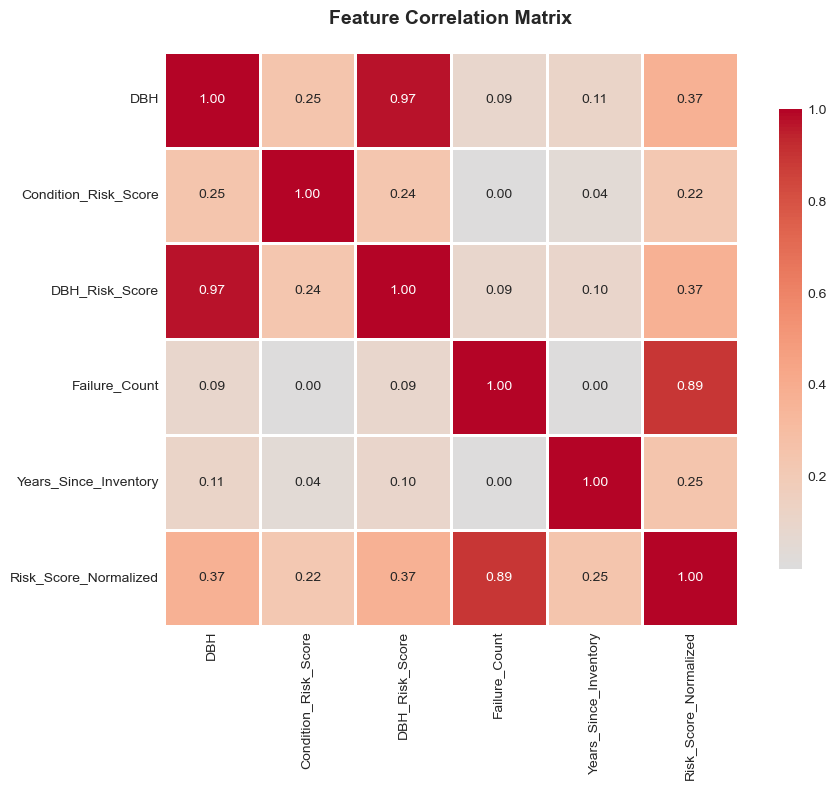


Correlation with Risk Score (Normalized):
Risk_Score_Normalized    1.000000
Failure_Count            0.893267
DBH_Risk_Score           0.374612
DBH                      0.370716
Years_Since_Inventory    0.248796
Condition_Risk_Score     0.222418
Name: Risk_Score_Normalized, dtype: float64


In [56]:
# Correlation analysis of key features
print("=== FEATURE CORRELATION ANALYSIS ===")

# Select numeric features for correlation
numeric_features = ['DBH', 'Condition_Risk_Score', 'DBH_Risk_Score', 
                    'Failure_Count', 'Years_Since_Inventory', 'Risk_Score_Normalized']

# Create correlation matrix
corr_data = prioritization_df[numeric_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation with Risk Score (Normalized):")
risk_correlations = corr_data['Risk_Score_Normalized'].sort_values(ascending=False)
print(risk_correlations)


## Key Findings Summary

### 1. **Species Analysis**
- Species is a critical factor in tree failure prediction
- Certain species show significantly higher failure rates
- Species-level risk scores can be used as a key feature in the prioritization model

### 2. **Tree Characteristics Correlating with Failures**
- **Condition**: Poor/Critical condition trees have higher failure rates
- **DBH (Size)**: Larger trees (higher DBH) tend to have more failures
- **Age**: Older trees (based on inventory date) may need more attention

### 3. **Failure Types**
- Branch failures are the most common type
- Tree failures and structural issues are also significant
- Different failure types may require different intervention strategies

### 4. **Temporal Patterns**
- Seasonal patterns may exist (storms, weather events)
- Yearly trends can help identify increasing/decreasing problem areas

### 5. **Geographic Patterns**
- District-level analysis can identify high-risk areas
- Location-based risk factors should be considered

### Next Steps for Model Development:
1. Use species risk scores as a primary feature
2. Incorporate condition, DBH, and age as features
3. Consider failure history (if available) as a strong predictor
4. Add geographic features (district, location)
5. Create a classification/regression model to predict failure probability
6. Use the risk scores to prioritize pruning schedules


In [57]:
# Export key datasets for model development
print("=== EXPORTING DATA FOR MODEL DEVELOPMENT ===")

# Save prioritization dataset
prioritization_df.to_csv('../../data/tree_prioritization_features.csv', index=False)
print("Saved: tree_prioritization_features.csv")

# Save species risk scores
if len(merged) > 0:
    species_risk_export = species_failure_rates.reset_index()
    species_risk_export.columns = ['Species', 'Total_Trees', 'Total_Failures', 'Failure_Rate']
    species_risk_export.to_csv('../../data/species_risk_scores.csv', index=False)
    print("Saved: species_risk_scores.csv")

# Save failure analysis summary
if len(merged) > 0:
    failure_summary = {
        'Total_Service_Requests': len(service_df),
        'Total_Matched_Requests': len(merged),
        'Match_Rate': len(merged) / len(service_df) * 100,
        'Top_Failure_Categories': service_df['Failure_Category'].value_counts().to_dict(),
        'Top_Risk_Species': species_failure_rates.head(10).to_dict('index')
    }
    import json
    with open('../../data/failure_analysis_summary.json', 'w') as f:
        json.dump(failure_summary, f, indent=2, default=str)
    print("Saved: failure_analysis_summary.json")

print("\nData export complete! Ready for model development.")


=== EXPORTING DATA FOR MODEL DEVELOPMENT ===
Saved: tree_prioritization_features.csv
Saved: species_risk_scores.csv
Saved: failure_analysis_summary.json

Data export complete! Ready for model development.
